In [4]:
from itertools import product

import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc3 as pm
import scanpy as sc

In [5]:
data_pth = "/home/alma/w-projects/sploc/data/visium/smallint/V19T26-028_A1"
adata = sc.read_visium(data_pth)


Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.


In [6]:
%config InlineBackend.figure_format = "retina"
RANDOM_SEED = 1337
np.random.seed(RANDOM_SEED)
az.style.use("arviz-darkgrid")

(7.155749999999999, 106.24925, 4.484375, 104.598125)

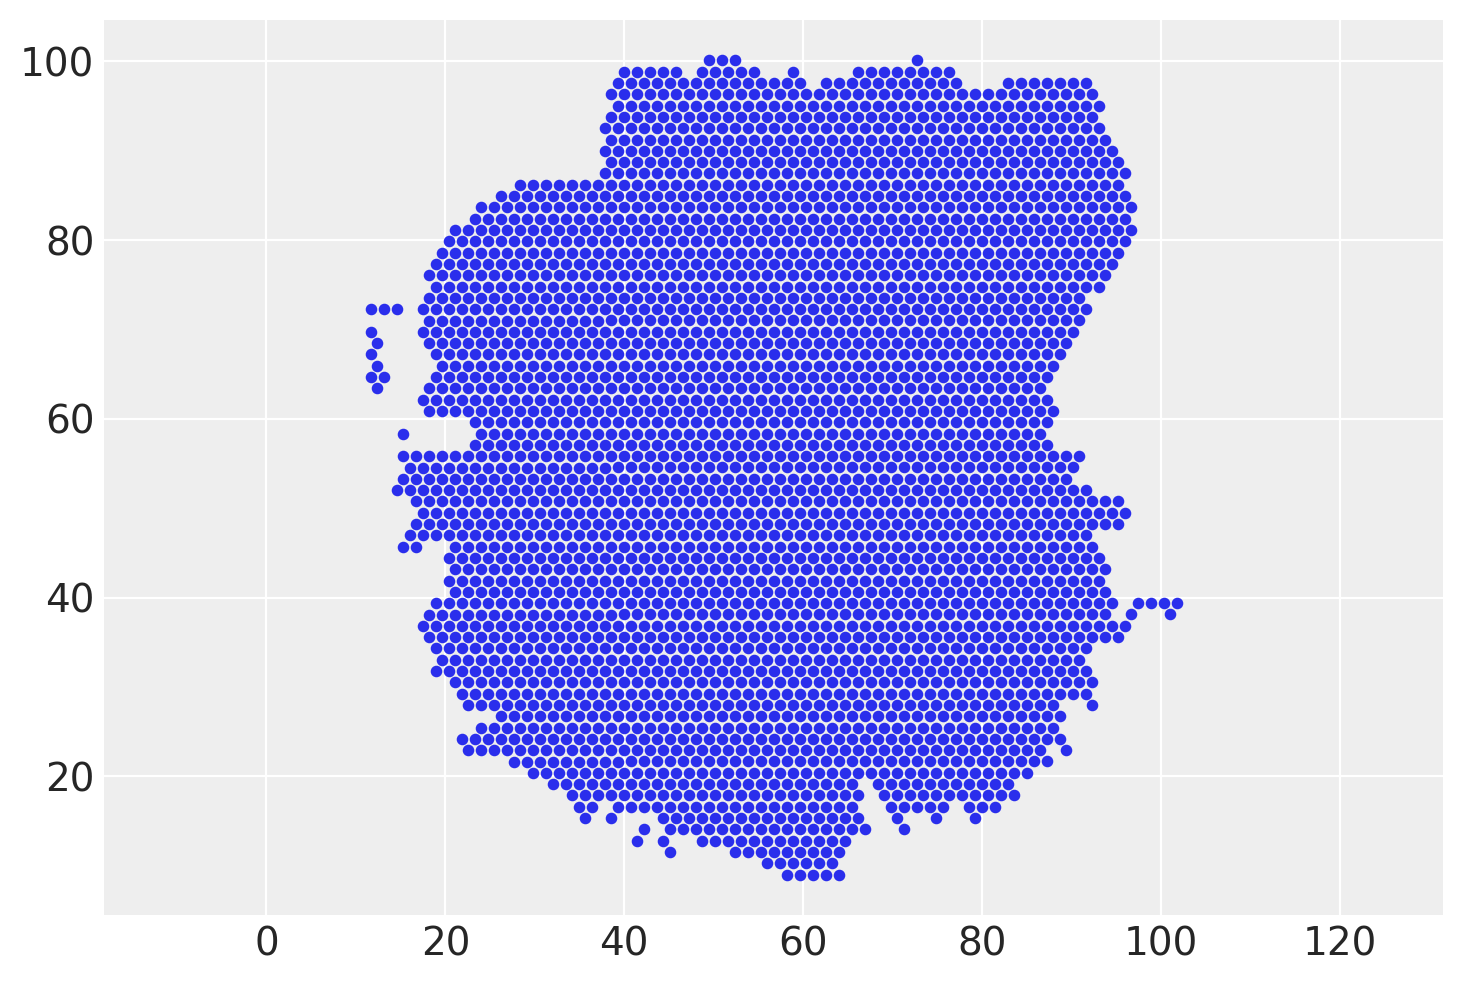

In [78]:
crd = adata.obsm["spatial"] / 400
plt.scatter(crd[:,0],crd[:,1],s=10)
plt.axis("equal")

In [36]:
adata.var.index[np.argsort(np.array(adata.X.sum(axis=0))[0])[::-1][20:30]]

Index(['RPS27', 'RPLP1', 'SPINK4', 'RPS29', 'TMSB4X', 'TFF3', 'S100A6',
       'TMSB10', 'RPS26', 'RPS12'],
      dtype='object')

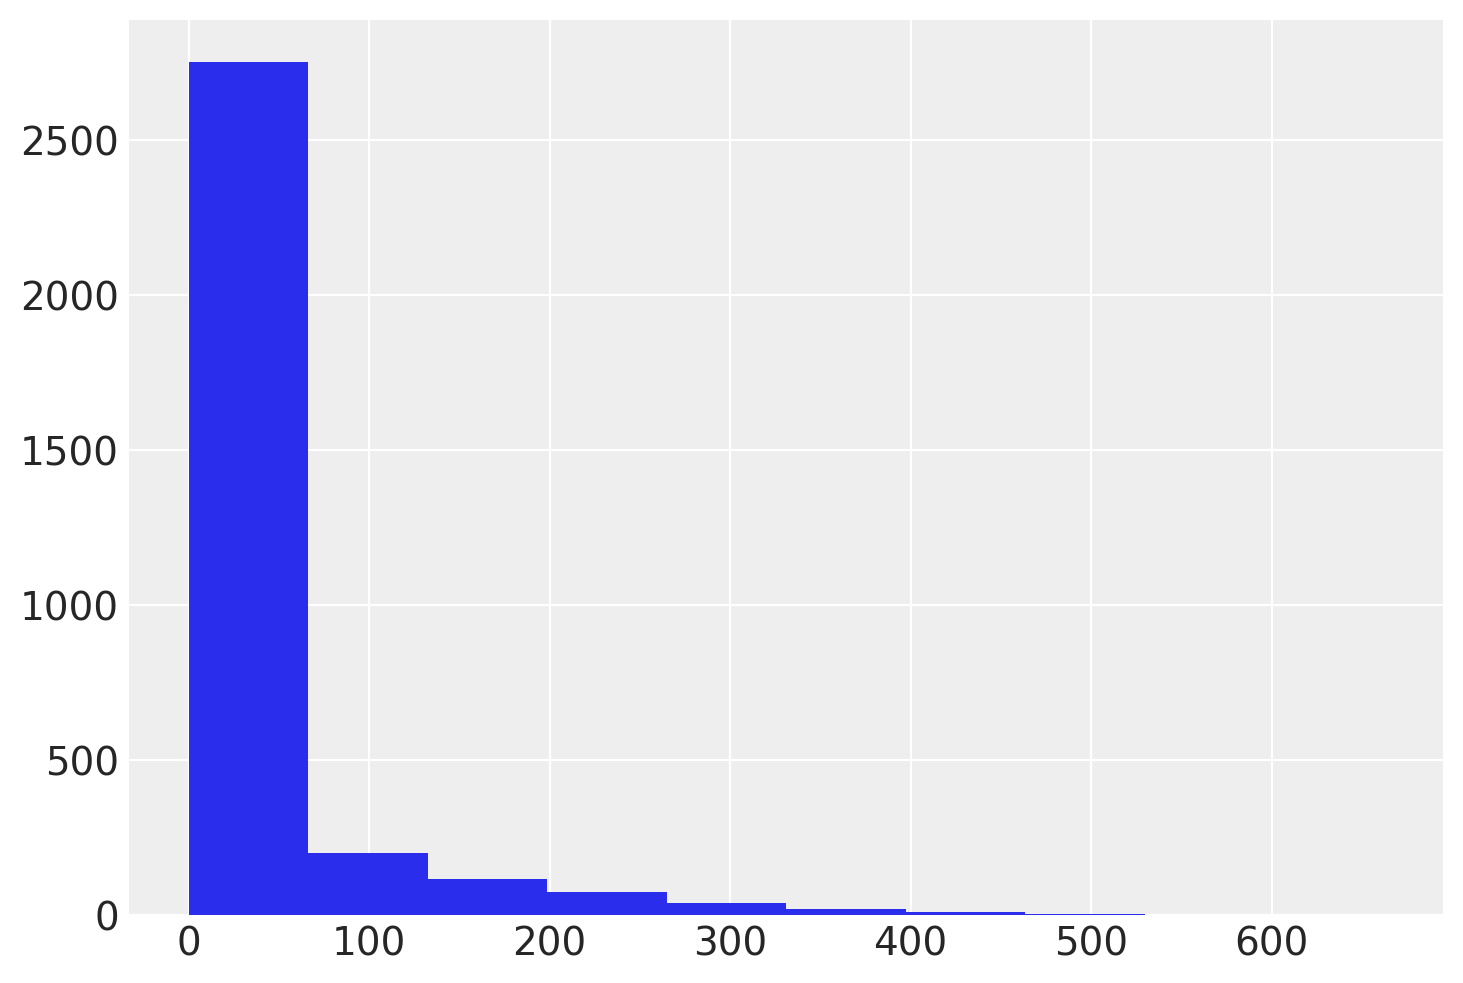

In [76]:
cell_counts = adata.obs_vector("SPINK4")
plt.hist(cell_counts,bins = 10)
plt.show()

In [79]:
area_per_cell = np.array(adata.X.sum(axis=1)) + 1
area_per_cell = np.log10(area_per_cell.flatten())

In [86]:
np.isinf(area_per_cell).sum()

0

In [92]:
with pm.Model() as lgcp_model:
    mu = pm.Normal("mu",sd = 3)
    rho = pm.Uniform("rho",lower=25,upper = 200)
    cov_scale = pm.Exponential("cov_scale",lam =1)
    
    cov_func = cov_scale * pm.gp.cov.ExpQuad(2,ls=rho)
    mean_func = pm.gp.mean.Constant(mu)
    
with lgcp_model:
    gp = pm.gp.Latent(mean_func=mean_func,cov_func=cov_func)
    
    log_intensity = gp.prior("log_intensity",X=crd[0:100,:])
    intensity = pm.math.exp(log_intensity)
    
    rates = intensity * area_per_cell[0:100]
    counts = pm.Poisson("counts",mu = rates, observed = cell_counts[0:100])
    

In [96]:
with lgcp_model:
    trace = pm.sample(target_accept = 0.9,
                      return_inferencedata=True,
                      )

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [log_intensity_rotated_, cov_scale, rho, mu]


ValueError: Not enough samples to build a trace.

In [51]:
x_new = np.linspace(crd[:,0].min(),crd[:,0].max(), 50)
y_new = np.linspace(crd[:,1].min(),crd[:,1].max(), 50)
xs, ys = np.asarray(np.meshgrid(x_new, y_new))
xy_new = np.asarray([xs.ravel(), ys.ravel()]).T

with lgcp_model:
    intensity_new = gp.conditional("intensity_new",Xnew = xy_new)
    new_samples = pm.sample_posterior_predictive(trace, var_names=["intensity_new"])
    
intensity_samples = np.asarray([x for x in new_samples["intensity_new"] if np.all(np.isfinite(x))])

NameError: name 'trace' is not defined

In [ ]:
fig = plt.figure(figsize=(5, 4))

plt.scatter(
    xy_new[:, 0],
    xy_new[:, 1],
    c=np.exp(intensity_samples).mean(axis=0),
    marker="o",
    alpha=0.75,
    s=100,
    edgecolor=None,
)

plt.title("$E[\\lambda(s) \\vert Y]$")
plt.colorbar(label="Posterior mean");


In [97]:
import math
import torch
import gpytorch
import pyro
import tqdm
import matplotlib.pyplot as plt


ModuleNotFoundError: No module named 'pyro'